# NaiveBayes

In [24]:
import numpy as np
import pandas as pd
from plotnine import *
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics as mt
import calendar

def procesar_csv(df):
    from sklearn import preprocessing
    
    # Convertirmos las columnas origin y destination a variables numericas 
    le = preprocessing.LabelEncoder()
    ciudades = ((pd.concat([df['origin'], df['destination']], ignore_index = True).drop_duplicates()).reset_index())[0]
    le.fit(ciudades)
    
    origin_as_int = le.fit_transform(df['origin'])
    destination_as_int = le.fit_transform(df["destination"])
    
    df["origin_int"] = origin_as_int
    df.drop('origin', axis=1, inplace=True)
    
    df["destination_int"] = destination_as_int
    df.drop('destination', axis=1, inplace=True)
    
    # Transformamos Columnas Continuas a Discretas
    revenues_usd_discr = pd.qcut(df["revenues_usd"], 10, [1,2,3,4,5,6,7,8,9,10] )
    df["revenues_usd_discr"] = revenues_usd_discr
    df.drop('revenues_usd', axis=1, inplace=True)
    
    # Cambiamos el formato del date y departure_time para saber el mes de la compra y el horario en el que se compra
    df["date"] = pd.to_datetime(df["date"], errors='coerce')
    df["mes"] = pd.DatetimeIndex(df["date"]).month
    
    df.departure_time = pd.to_datetime(df.departure_time, errors='coerce')
    bins = [0,12,18,24]
    labels = [1,2,3]
    df['horario'] = pd.cut(df["departure_time"].dt.hour, bins, labels=labels, right=False)
    
    
    df.drop('departure_time', axis=1, inplace=True)
    df.drop('date', axis=1, inplace=True)
    
    # Eliminar columnas sin uso
    df.drop('Unnamed: 0', axis=1, inplace=True)
    
    # retornamos el data frame modificado sin valore nulos.
    return df.dropna()

In [25]:
# Leemos los datos
df = pd.read_csv("ALUMNOS-trainData.csv")
# Procesamos los datos con la funcion procesar_csv()
df = procesar_csv(df)
# transformamos los datos a binarios
df["Labels"] = np.where(df["noshow"] >= 4, 1,0)
# Definimos nuestra columna target
target = df['Labels']
# La eliminamos del dataframe
df.drop('noshow', axis=1, inplace=True)


#Columnas despues de la limpieza
df.columns

Index(['fligth_number', 'distance', 'denied_boarding', 'pax_midlow',
       'pax_high', 'pax_midhigh', 'pax_low', 'pax_freqflyer', 'group_bookings',
       'out_of_stock', 'dom_cnx', 'int_cnx', 'p2p', 'capacity', 'bookings',
       'origin_int', 'destination_int', 'revenues_usd_discr', 'mes', 'horario',
       'Labels'],
      dtype='object')

display(df)
for i in df.columns:
    display(df[i].value_counts())
    display(df[i].isna())

In [45]:
#display(df)
#for i in df.columns:
    #print(i)
    #display(df[i].value_counts())
    #display(df.hist(column = i, bins = 5, grid = False))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df["capacity"].value_counts().to_frame())

            capacity
174.000000    402063
144.000000    199905
220.000000    116525
168.000000     67504
218.000000     49406
150.000000     27765
216.000000     13944
156.000000     13076
126.000000     10403
323.000000      7522
187.000000      7064
270.000000      5943
191.000000      5551
213.000000      4891
217.000000      4552
272.000000      3545
173.000000      3475
189.000000      3385
274.000000      3331
215.000000      2633
309.000000      2274
219.000000      2236
221.000000      2105
172.000000      1880
135.000000      1835
212.000000      1827
143.000000      1812
170.000000      1792
132.000000      1714
169.000000      1409
208.000000      1221
227.000000      1216
165.000000       993
209.000000       979
128.000000       898
157.000000       873
322.000000       714
154.000000       592
56.000000        582
138.000000       577
142.000000       568
123.000000       567
171.000000       565
283.000000       547
160.000000       533
120.000000       523
281.000000   

In [8]:
#Crear un objeto de KFold cross validation

#for k in range (2,100, 5):
kf = KFold(n_splits = 100, shuffle = True, random_state = 0)

#Crear arreglos para guardar los errores de cada fold (tanto para entrenamiento como test).
F1Train = np.zeros(100)
F1Test = np.zeros(100)

#Crear el objeto de Naive Bayes que estime correspondiente, con el alpha deseado
NB = GaussianNB(var_smoothing = 1)
i=0

#Aplicar K-fold cross validation
for train_index, test_index in kf.split(df):
        #extraer los datos de entrenamiento y test
        trainData = df.iloc[train_index, :]
        testData = df.iloc[test_index, :]

        trainLabel = target.iloc[train_index]
        testLabel = target.iloc[test_index]

        #Entrenar el modelo usando los datos de entrenamiento
        NB = NB.fit(trainData, trainLabel)

        #Predecir los valores de TrainData y calcule su error
        prediccion = NB.predict(trainData)
        F1Train[i] = mt.f1_score(trainLabel, prediccion)
    
        #Prediga los valores de testData y calcule su error
        prediccion = NB.predict(testData)
        F1Test[i] = mt.f1_score(testLabel, prediccion, pos_label = 1)

        i+=1

print("Numero iteraciónes: ", i)
print("F1-score modelo para training: ", F1Train.mean(), "+-", F1Train.std())   
print("F1-score modelo para test: ", F1Test.mean(), "+-", F1Test.std())  

Numero iteraciónes:  100
F1-score modelo para training:  0.7919559056332888 +- 3.5307737062786766e-05
F1-score modelo para test:  0.7919457801248194 +- 0.0034956845297918256


In [9]:
#Muestre la media y desviación estandar de cada error 
print("F1-score modelo para training: ", F1Train.mean(), "+-", F1Train.std())   
print("F1-score modelo para test: ", F1Test.mean(), "+-", F1Test.std())   

F1-score modelo para training:  0.7919559056332888 +- 3.5307737062786766e-05
F1-score modelo para test:  0.7919457801248194 +- 0.0034956845297918256


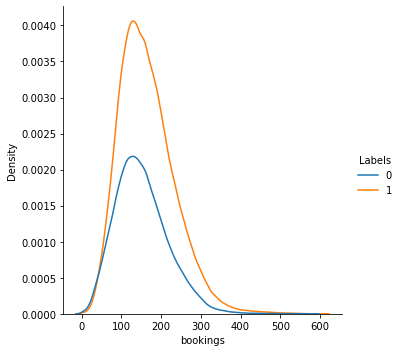

In [10]:
sns.displot(df, x='bookings', hue ="Labels", kind = 'kde')

In [11]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df,target,test_size=0.33, random_state=42)


In [49]:
#Creando un objeto Naive Bayes con las condiciones iniciales
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB(var_smoothing = )
NB = NB.fit(X_train,y_train)

#Aplicando el modelo a otros datos
resultado=NB.predict(X_test)
print("Resultado de la predicción:\n",resultado)
print("Resultado original:\n",y_test)

#Aplicando el modelo a otros datos
resultados=NB.predict_proba(X_test)
print("Resultado de la predicción:\n",resultados)

Resultado de la predicción:
 [1 1 1 ... 1 1 1]
Resultado original:
 118754    1
557683    1
920464    0
342002    1
795703    0
         ..
437790    1
21087     1
772657    0
276786    0
447843    1
Name: Labels, Length: 329496, dtype: int64
Resultado de la predicción:
 [[0.34162792 0.65837208]
 [0.33938107 0.66061893]
 [0.34102982 0.65897018]
 ...
 [0.34417907 0.65582093]
 [0.32345821 0.67654179]
 [0.3147215  0.6852785 ]]


In [50]:
mt.f1_score(y_test, resultado, pos_label = 1)

0.7920328189786963

In [51]:
print("Clases:\n",df["Labels"].unique())
print("características:\n",df.columns)
print("\nDistribución a prior (P(C)):\n",NB.class_prior_)
print("\nMedias:\n",NB.theta_)
print("\nDesviación estandar (sqrt de sigma):\n",np.sqrt(NB.sigma_))

Clases:
 [1 0]
características:
 Index(['fligth_number', 'distance', 'denied_boarding', 'pax_midlow',
       'pax_high', 'pax_midhigh', 'pax_low', 'pax_freqflyer', 'group_bookings',
       'out_of_stock', 'dom_cnx', 'int_cnx', 'p2p', 'capacity', 'bookings',
       'origin_int', 'destination_int', 'revenues_usd_discr', 'mes', 'horario',
       'Labels'],
      dtype='object')

Distribución a prior (P(C)):
 [0.34448321 0.65551679]

Medias:
 [[5.82191942e+03 1.47606202e+03 6.30589583e-02 7.38713306e+01
  3.78970801e+00 6.04682991e+00 5.11962543e+01 1.58840665e+01
  4.97485366e+00 9.88843615e-02 2.55039943e+01 2.97408213e+01
  9.55433736e+01 1.72642640e+02 1.50788189e+02 6.07777445e+01
  6.61884826e+01 5.52550868e+00 6.56020152e+00 1.86796759e+00
  0.00000000e+00]
 [6.26479195e+03 1.45397872e+03 3.90468046e-02 7.63725512e+01
  3.82651160e+00 6.47302434e+00 6.04029554e+01 1.72695810e+01
  3.22839519e+00 9.47243601e-02 2.59631059e+01 2.51640864e+01
  1.13217431e+02 1.80960970e+02 1.64344623e

0: 5821.919423217951 +- 2944.977077239505
1: 6264.791945727154 +- 2862.452116987951


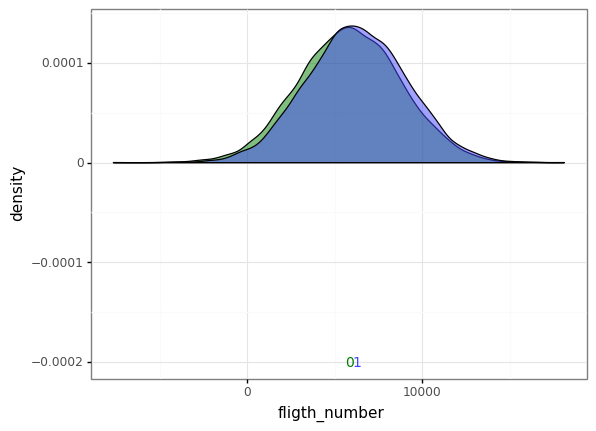

<ggplot: (8761796892127)>

0: 1476.0620218614804 +- 2613.331236017368
1: 1453.978721851662 +- 2673.6578721247306


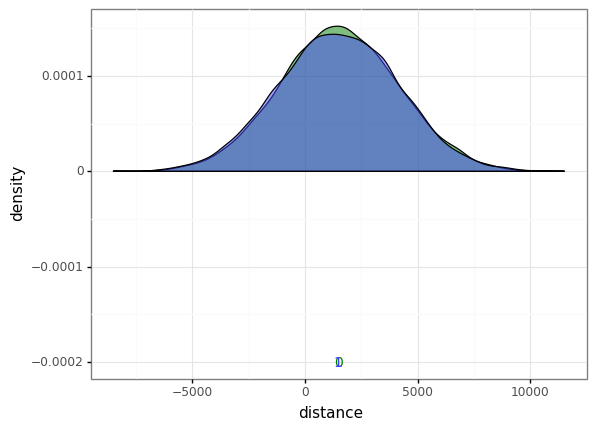

<ggplot: (8761827297871)>

0: 0.06305895830350053 +- 2049.7584699946133
1: 0.03904680462915455 +- 2049.7584343442168


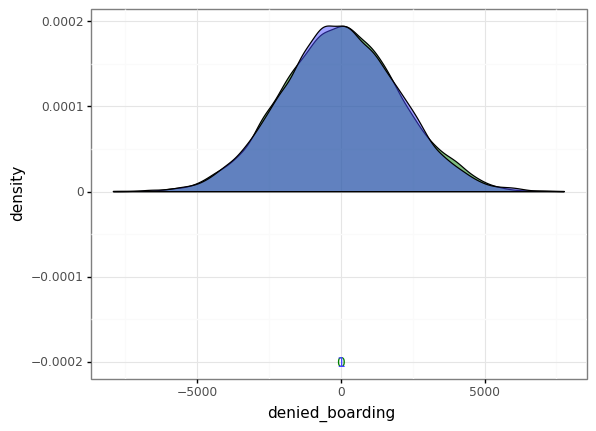

<ggplot: (8761796707024)>

0: 73.87133056484893 +- 2050.1911709462142
1: 76.37255116584004 +- 2050.2702029782117


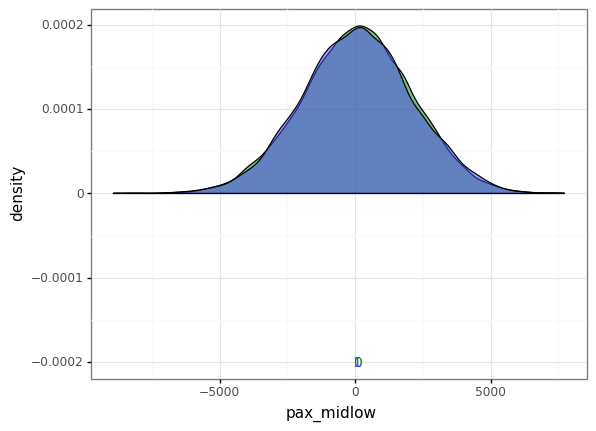

<ggplot: (8761796706865)>

0: 3.7897080073421248 +- 2049.772269192252
1: 3.8265116013910268 +- 2049.770632523475


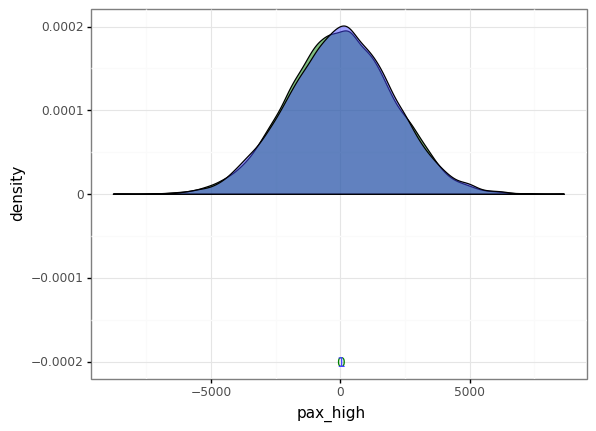

<ggplot: (8761809483108)>

0: 6.04682991178168 +- 2049.7845073727253
1: 6.4730243429679035 +- 2049.784013876612


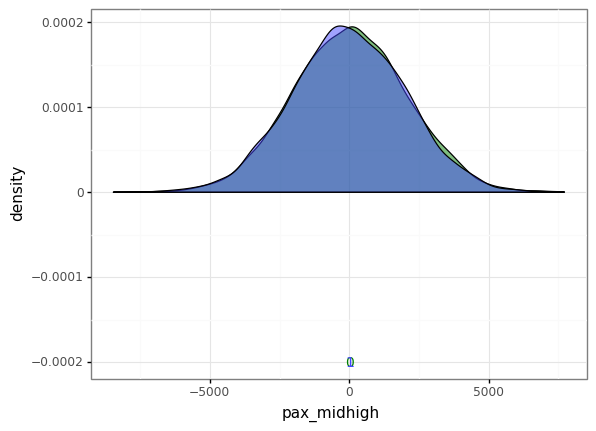

<ggplot: (8761809483129)>

0: 51.196254301348226 +- 2050.0744599335944
1: 60.40295536172396 +- 2050.133823590153


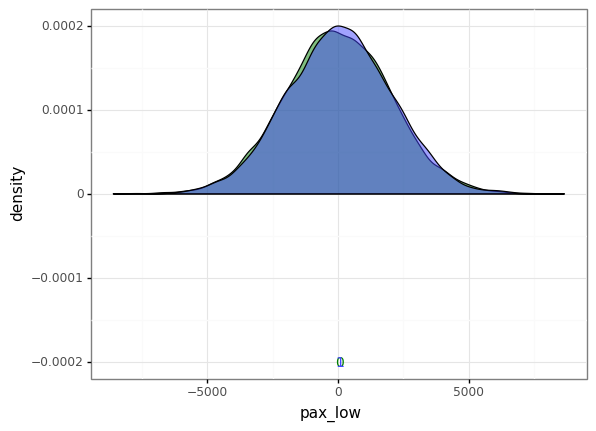

<ggplot: (8761796986052)>

0: 15.884066460983028 +- 2049.8010856456217
1: 17.269580981700017 +- 2049.8069651844003


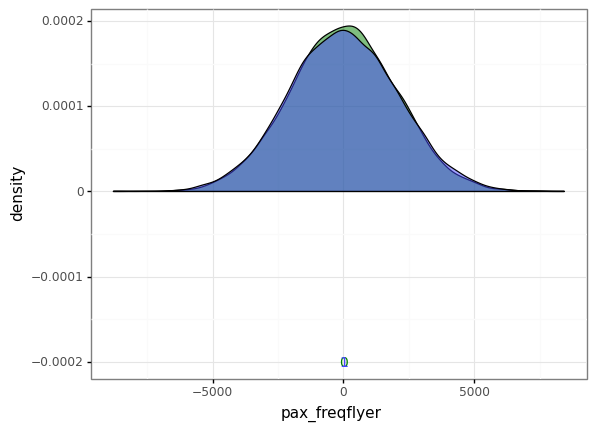

<ggplot: (8761809364146)>

0: 4.974853656525682 +- 2049.8085558328503
1: 3.228395188415712 +- 2049.787851877926


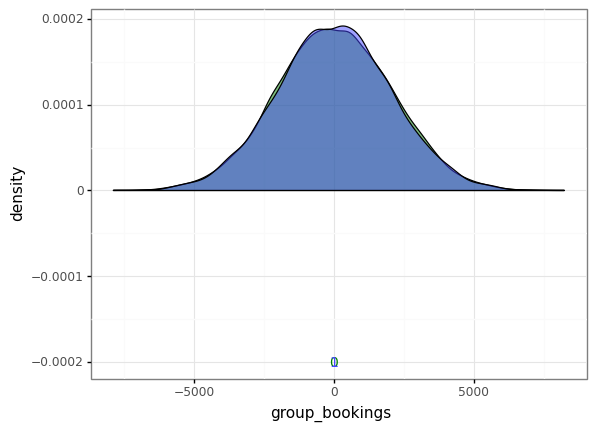

<ggplot: (8761797116103)>

0: 0.09888436153455615 +- 2049.758395750726
1: 0.09472436007069153 +- 2049.758394932437


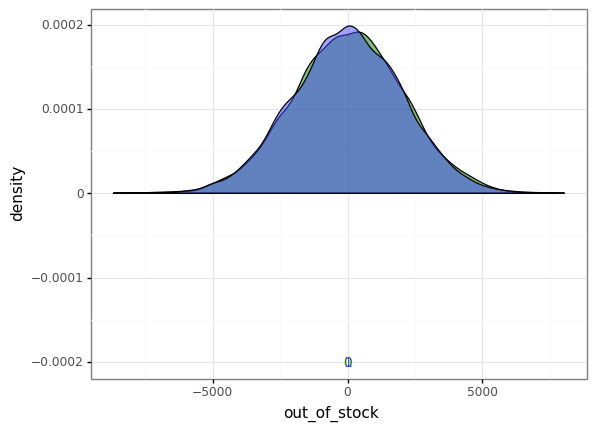

<ggplot: (8761796394665)>

0: 25.503994341530305 +- 2050.026652024432
1: 25.9631058662562 +- 2050.0033593544235


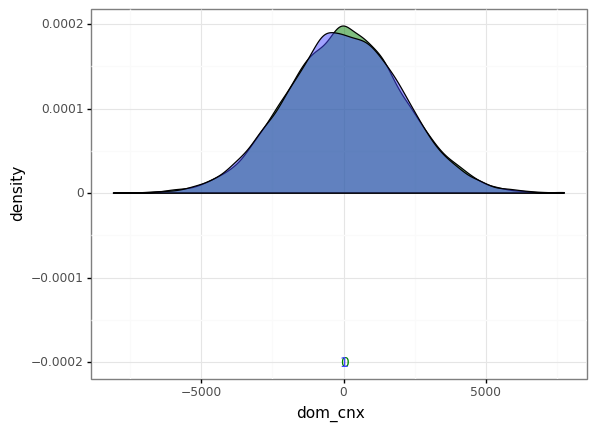

<ggplot: (8761796899548)>

0: 29.74082125918308 +- 2050.266950888893
1: 25.16408642608745 +- 2050.208332990108


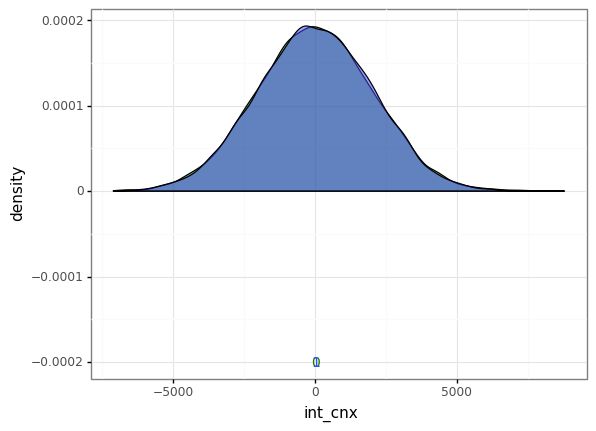

<ggplot: (8761796820721)>

0: 95.5433736455906 +- 2050.6943699954327
1: 113.2174311612793 +- 2050.8371581599413


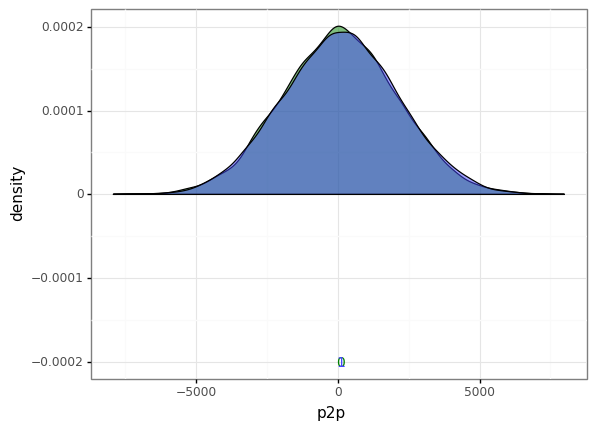

<ggplot: (8761809440223)>

0: 172.64263985059043 +- 2049.9755896655224
1: 180.96097047624494 +- 2050.036451153528


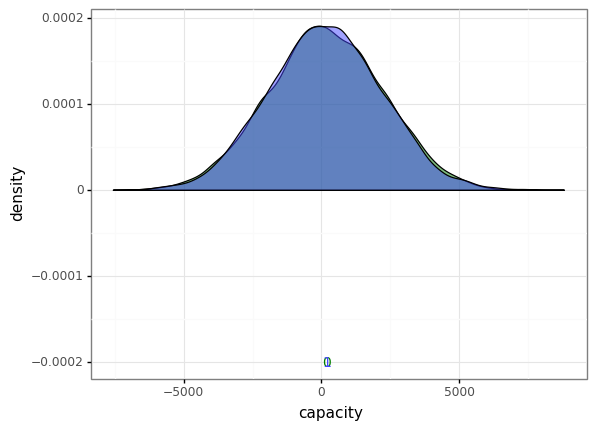

<ggplot: (8761796675663)>

0: 150.788189246304 +- 2050.8226250964794
1: 164.34462345362294 +- 2050.935064351637


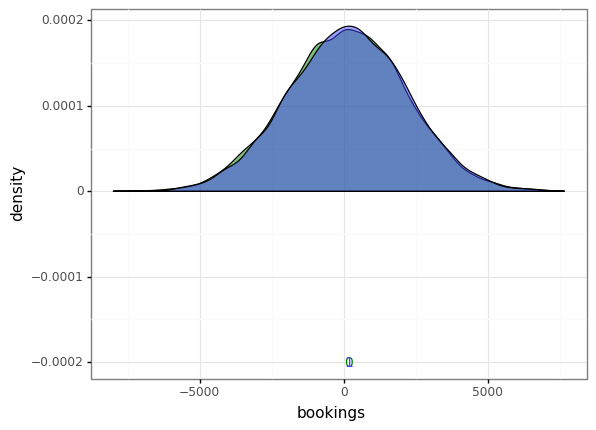

<ggplot: (8761796932518)>

0: 60.77774450967885 +- 2050.1764753145853
1: 67.42181403568782 +- 2050.1927198631965


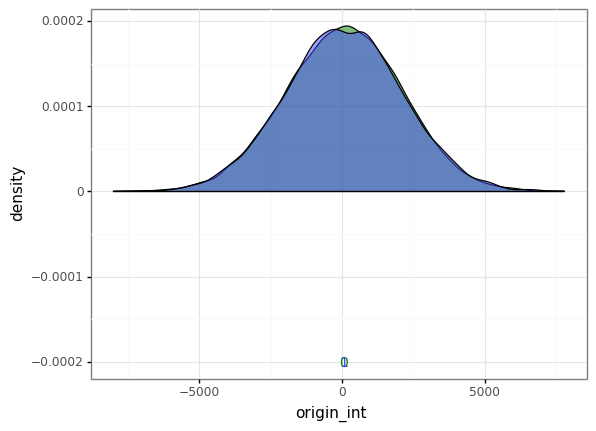

<ggplot: (8761797274974)>

0: 66.18848258415021 +- 2050.233457227072
1: 66.87903312239895 +- 2050.202657825668


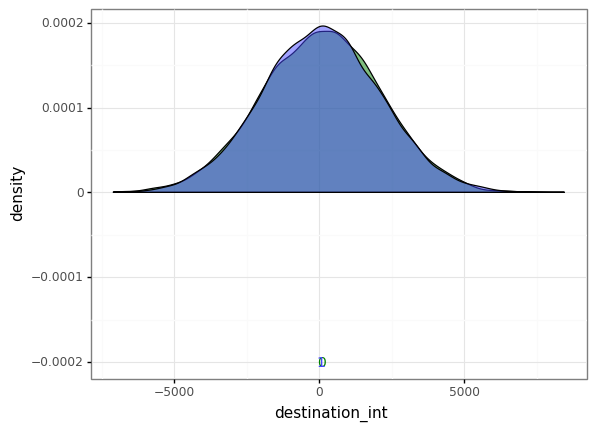

<ggplot: (8761797270266)>

0: 5.525508676464845 +- 2049.7605331937716
1: 5.492995838321646 +- 2049.7603043546824


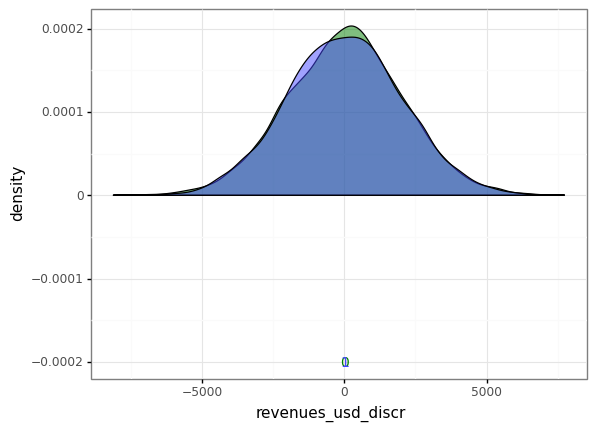

<ggplot: (8761797269023)>

0: 6.560201517893175 +- 2049.7614619696556
1: 6.6924006613077935 +- 2049.7613687951853


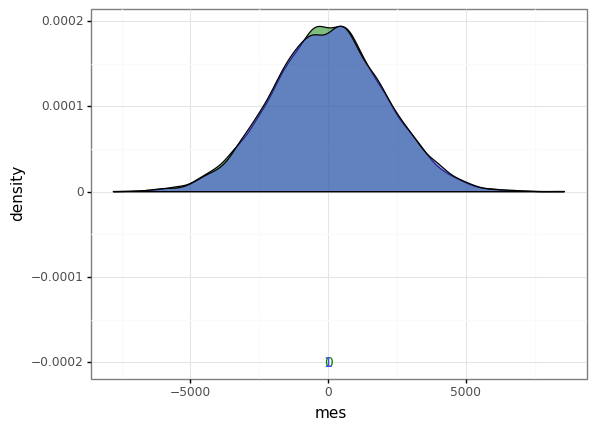

<ggplot: (8761796277074)>

0: 1.8679675939787634 +- 2049.758534753347
1: 1.8476164414799612 +- 2049.7585340297396


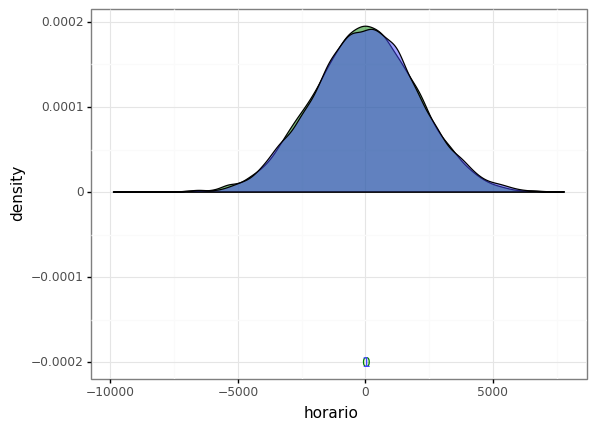

<ggplot: (8761796565339)>

In [52]:
#Visualización de las distribuciones
tempDF=pd.DataFrame(np.zeros((10000,2)),columns=["0","1"])
for variable in range(20):
    varSeleccionada=variable
    for i in range(2):
        tempDF.iloc[:,i] = np.random.normal(NB.theta_[i][varSeleccionada], np.sqrt(NB.sigma_[i][varSeleccionada]), 10000) 
    print("0:", NB.theta_[0][varSeleccionada], "+-" ,np.sqrt(NB.sigma_[0][varSeleccionada]))
    print("1:", NB.theta_[1][varSeleccionada], "+-" ,np.sqrt(NB.sigma_[1][varSeleccionada]))
    display(ggplot(tempDF)+theme_bw()+
     geom_density(aes(x="0"),fill="#007F00",alpha=0.5)+
     geom_density(aes(x="1"),fill="#4446FF",alpha=0.5)+
     annotate("text",x=NB.theta_[0][varSeleccionada],y=-0.0002,label=0,color="#007F00",size=10)+
     annotate("text",x=NB.theta_[1][varSeleccionada],y=-0.0002,label=1,color="#4446FF",size=10)+
     labs(y="density",x=df.columns[varSeleccionada])
    )

Límites [2 1]


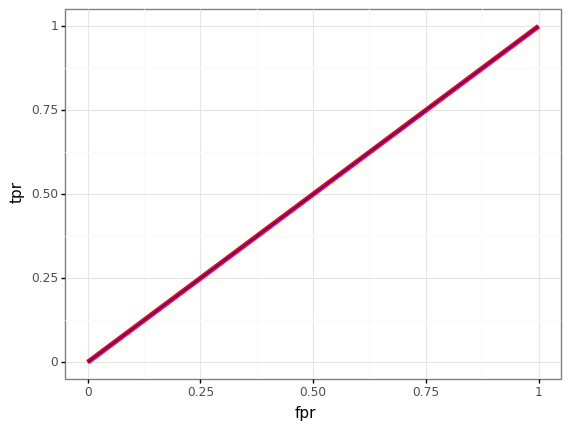


Valor del AUC: 0.5


In [55]:
#Calculando los tpr and fpr
from sklearn import metrics as mt
fpr, tpr, thresholds = mt.roc_curve(y_test, resultado, pos_label = 1)
print("Límites",thresholds)

tempDF=pd.DataFrame(zip(fpr,tpr),columns=["fpr","tpr"])
#Curva ROC
print(ggplot(tempDF)+aes(x="fpr",y="tpr")+geom_line(color="red",size=2)+
    annotate("segment",x=0,y=0,xend=1,yend=1,color="blue")+
    theme_bw()
)

#Valor del AUC
print("Valor del AUC:",mt.auc(fpr,tpr))